### 생성자를 언제든 생성할 수 있도록 함수 만듦

# CIFAR-10 이미지 생성하기
### 들어가기
- 이미지 데이터 shape (32, 32, 3). 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향
- RGB 3채널의 컬러이미지. 시각화 과정에서 고려

In [9]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.0


In [10]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

## 데이터셋 구성하기

In [11]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

### train_x 이미지 보기

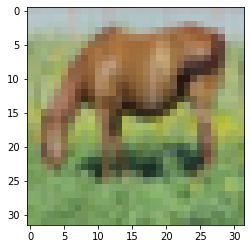

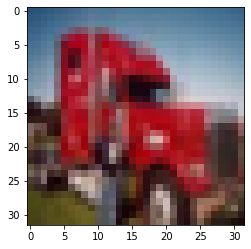

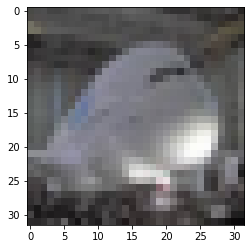

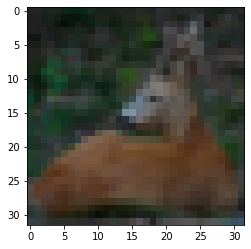

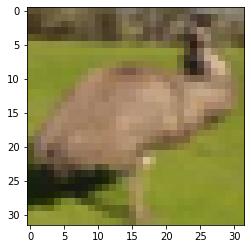

In [12]:
cand = np.random.randint(1, 50000, 5)
for i in cand:
    plt.imshow(train_x[i])
    plt.show()

### train_x -1, 1로 정규화

In [13]:
print(f'min is {train_x[0].min()}, max is {train_x[0].max()}')
train_x = (train_x - 127.5) / 127.5
print(f'min ins {train_x[0].min()}, max is {train_x[0].max()}')

min is 0, max is 255
min ins -1.0, max is 1.0


### 미니배치 데이터셋을 구성
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용
- 너무 많은 양을 한 번에 학습시키면 메모리 활용 면에서 비효율적이고, 한 번 학습을 하는 데에도 오래 걸리므로 적절한 사이즈로 잘라서 학습

In [14]:
# BUFFER_SIZE는 전체 데이터를 섞기 위해 60000 (총 데이터 수와 같거나 크게 설정하는 것이 좋음)

BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [16]:
## 생성자 모델 구현하기

In [17]:
def make_generator_model():

    print('start')

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layerㅇㅇ
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    print('end')

    return model

In [18]:
generator = make_generator_model()

generator.summary()

start
end
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)

### 랜덤 이미지 생성
방금 구현한 생성자에 `noise = tf.random.normal([1, 100])`로 생성된 랜덤 노이즈를 입력

In [19]:
noise = tf.random.normal([1, 100])

In [20]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

### 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

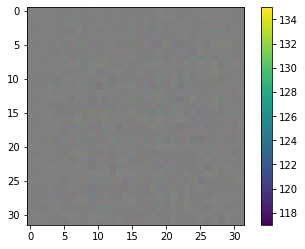

In [21]:
plt.imshow(tf.reshape(tf.dtypes.cast(generated_image * 127.5 + 127.5, tf.int64), [32,32,3]))
plt.colorbar()
plt.show()


In [22]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [23]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

### 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인

In [24]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00478098]], dtype=float32)>

## 손실함수와 최적화 함수 구현
### 생성자와 판별자의 손실함수(loss)를 구현

In [25]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [26]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [27]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현

In [28]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

생성자와 판별자를 최적화하는 optimizer를 정의

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [30]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련과정 상세 기능 구현
### train_step(): 1개 미니배치의 훈련 과정을 처리

In [31]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### generate_and_save_images(): 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화

In [32]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(tf.reshape(tf.dtypes.cast(predictions[i] * 127.5 + 127.5, tf.int64), [32,32,3]))
        plt.axis('off')
   
    plt.savefig('{}/aiffel/explorations/13_cifar10_dcgan/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### draw_train_history(): 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화

In [33]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/explorations/13_cifar10_dcgan/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### training_checkpoints(dir): 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정

In [34]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/explorations/13_cifar10_dcgan/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [35]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [36]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

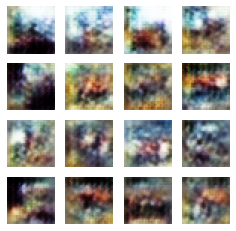

Time for training : 702 sec


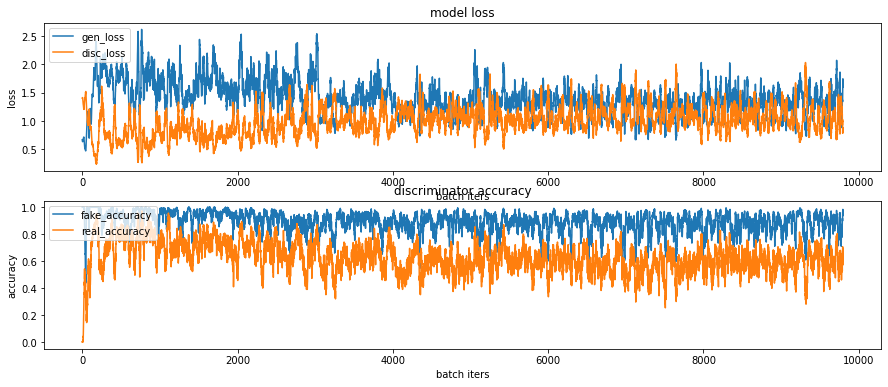

CPU times: user 11min 16s, sys: 31.8 s, total: 11min 48s
Wall time: 11min 43s


In [29]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/explorations/13_cifar10_dcgan/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [52]:
!ls ~/aiffel/explorations/13_cifar10_dcgan/cifar10/training_checkpoints

checkpoint		      ckpt-194.data-00000-of-00001
ckpt-1.data-00000-of-00001    ckpt-194.index
ckpt-1.index		      ckpt-195.data-00000-of-00001
ckpt-10.data-00000-of-00001   ckpt-195.index
ckpt-10.index		      ckpt-196.data-00000-of-00001
ckpt-100.data-00000-of-00001  ckpt-196.index
ckpt-100.index		      ckpt-197.data-00000-of-00001
ckpt-101.data-00000-of-00001  ckpt-197.index
ckpt-101.index		      ckpt-198.data-00000-of-00001
ckpt-102.data-00000-of-00001  ckpt-198.index
ckpt-102.index		      ckpt-199.data-00000-of-00001
ckpt-103.data-00000-of-00001  ckpt-199.index
ckpt-103.index		      ckpt-2.data-00000-of-00001
ckpt-104.data-00000-of-00001  ckpt-2.index
ckpt-104.index		      ckpt-20.data-00000-of-00001
ckpt-105.data-00000-of-00001  ckpt-20.index
ckpt-105.index		      ckpt-200.data-00000-of-00001
ckpt-106.data-00000-of-00001  ckpt-200.index
ckpt-106.index		      ckpt-201.data-00000-of-00001
ckpt-107.data-00000-of-00001  ckpt-201.index
ckpt-107.index		      ckpt-202.data-00000-of-00001
ck

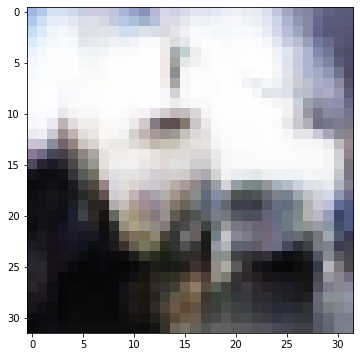

In [55]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/explorations/13_cifar10_dcgan/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalizationa
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

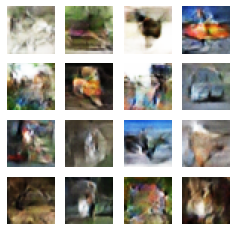

Epoch 784 | iter 51
Time for epoch 784 : 3 sec


In [32]:
%%time
train(train_dataset, 1000, save_every)

In [56]:
anim_file = os.getenv('HOME')+'/aiffel/explorations/13_cifar10_dcgan/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/explorations/13_cifar10_dcgan/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/explorations/13_cifar10_dcgan/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 4317864 Nov 15 12:03 /home/innoacad04/aiffel/explorations/13_cifar10_dcgan/cifar10/cifar10_dcgan.gif
